In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import sys

if "../" not in sys.path:
    sys.path.append("../")
    print("[sys.path]:", sys.path)

In [32]:
import tqdm

from src.data.babel import BabelDataset

In [33]:
train_dataset = BabelDataset(
    split="train",
    pipeline="babel"
)
validation_dataset = BabelDataset(
    split="validation",
    pipeline="babel"
)

Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.


In [34]:
print("[#train_dataset]:", len(train_dataset))
print("[#validation_dataset]:", len(validation_dataset))

[#train_dataset]: 6615
[#validation_dataset]: 2193


In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter, defaultdict

from src.constants import (
    DEFAULT_FPS
)

In [36]:
plt.style.use('default')
sns.set_palette("husl")

In [39]:
def analyze_prompts(dataset, dataset_name="Dataset"):
    all_prompts = []
    sample_prompt_counts = []
    source_counts = Counter()
    is_sequence_counts = Counter()
    durations = []
    sequence_durations = []
    frame_durations = []
    spans_per_prompt = defaultdict(list)
    
    for i, sample in enumerate(tqdm.tqdm(dataset)):
        prompts_list = sample.get("prompts", [])
        sample_prompt_counts.append(len(prompts_list))
        
        for prompt_data in prompts_list:
            prompt_text = prompt_data.get("text", "")
            span = prompt_data.get("span", [])
            source = prompt_data.get("source", "unknown")
            is_sequence = prompt_data.get("is_sequence", True)
            
            all_prompts.append(prompt_text)
            source_counts[source] += 1
            is_sequence_counts[is_sequence] += 1
            
            if len(span) == 2:
                duration_frames = span[1] - span[0]
                durations.append(duration_frames)
                spans_per_prompt[prompt_text].append(span)
                
                if is_sequence:
                    sequence_durations.append(duration_frames)
                else:
                    frame_durations.append(duration_frames)
    
    return {
        'all_prompts': all_prompts,
        'sample_prompt_counts': sample_prompt_counts,
        'source_counts': source_counts,
        'is_sequence_counts': is_sequence_counts,
        'durations': durations,
        'sequence_durations': sequence_durations,
        'frame_durations': frame_durations,
        'spans_per_prompt': spans_per_prompt,
        'dataset_name': dataset_name
    }

In [40]:
train_analysis = analyze_prompts(train_dataset, "Train")
validation_analysis = analyze_prompts(validation_dataset, "Validation")

100%|██████████| 2193/2193 [02:18<00:00, 15.87it/s]


In [41]:
print("=== BASIC STATISTICS ===")
print(f"Train Dataset: {len(train_dataset)} samples")
print(f"Validation Dataset: {len(validation_dataset)} samples")
print()

for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    print(f"{name} Dataset:")
    print(f"  Total prompts: {len(analysis['all_prompts'])}")
    print(f"  Unique prompts: {len(set(analysis['all_prompts']))}")
    print(f"  Avg prompts per sample: {np.mean(analysis['sample_prompt_counts']):.2f}")
    print(f"  Min prompts per sample: {np.min(analysis['sample_prompt_counts'])}")
    print(f"  Max prompts per sample: {np.max(analysis['sample_prompt_counts'])}")
    print()
    
    print(f"  Source distribution:")
    for source, count in analysis['source_counts'].items():
        print(f"    {source}: {count} ({count/len(analysis['all_prompts'])*100:.1f}%)")
    print()
    
    print(f"  Sequence vs Frame annotations:")
    for is_seq, count in analysis['is_sequence_counts'].items():
        label = "Sequence" if is_seq else "Frame"
        print(f"    {label}: {count} ({count/len(analysis['all_prompts'])*100:.1f}%)")
    print()
    
    if analysis['durations']:
        print(f"  Duration statistics (frames):")
        print(f"    Min: {np.min(analysis['durations'])} frames ({np.min(analysis['durations'])/DEFAULT_FPS:.2f}s)")
        print(f"    Mean: {np.mean(analysis['durations']):.2f} frames ({np.mean(analysis['durations'])/DEFAULT_FPS:.2f}s)")
        print(f"    Max: {np.max(analysis['durations'])} frames ({np.max(analysis['durations'])/DEFAULT_FPS:.2f}s)")
        print(f"    Std: {np.std(analysis['durations']):.2f} frames ({np.std(analysis['durations'])/DEFAULT_FPS:.2f}s)")
    print("-" * 50)

=== BASIC STATISTICS ===
Train Dataset: 6615 samples
Validation Dataset: 2193 samples

Train Dataset:
  Total prompts: 143365
  Unique prompts: 9422
  Avg prompts per sample: 21.67
  Min prompts per sample: 3
  Max prompts per sample: 330

  Source distribution:
    proc_label: 43137 (30.1%)
    raw_label: 43137 (30.1%)
    act_cat: 57091 (39.8%)

  Sequence vs Frame annotations:
    Sequence: 22720 (15.8%)
    Frame: 120645 (84.2%)

  Duration statistics (frames):
    Min: -51 frames (-2.55s)
    Mean: 72.96 frames (3.65s)
    Max: 5271 frames (263.55s)
    Std: 164.16 frames (8.21s)
--------------------------------------------------
Validation Dataset:
  Total prompts: 52433
  Unique prompts: 4336
  Avg prompts per sample: 23.91
  Min prompts per sample: 3
  Max prompts per sample: 331

  Source distribution:
    proc_label: 15744 (30.0%)
    raw_label: 15744 (30.0%)
    act_cat: 20945 (39.9%)

  Sequence vs Frame annotations:
    Sequence: 7794 (14.9%)
    Frame: 44639 (85.1%)

  Du

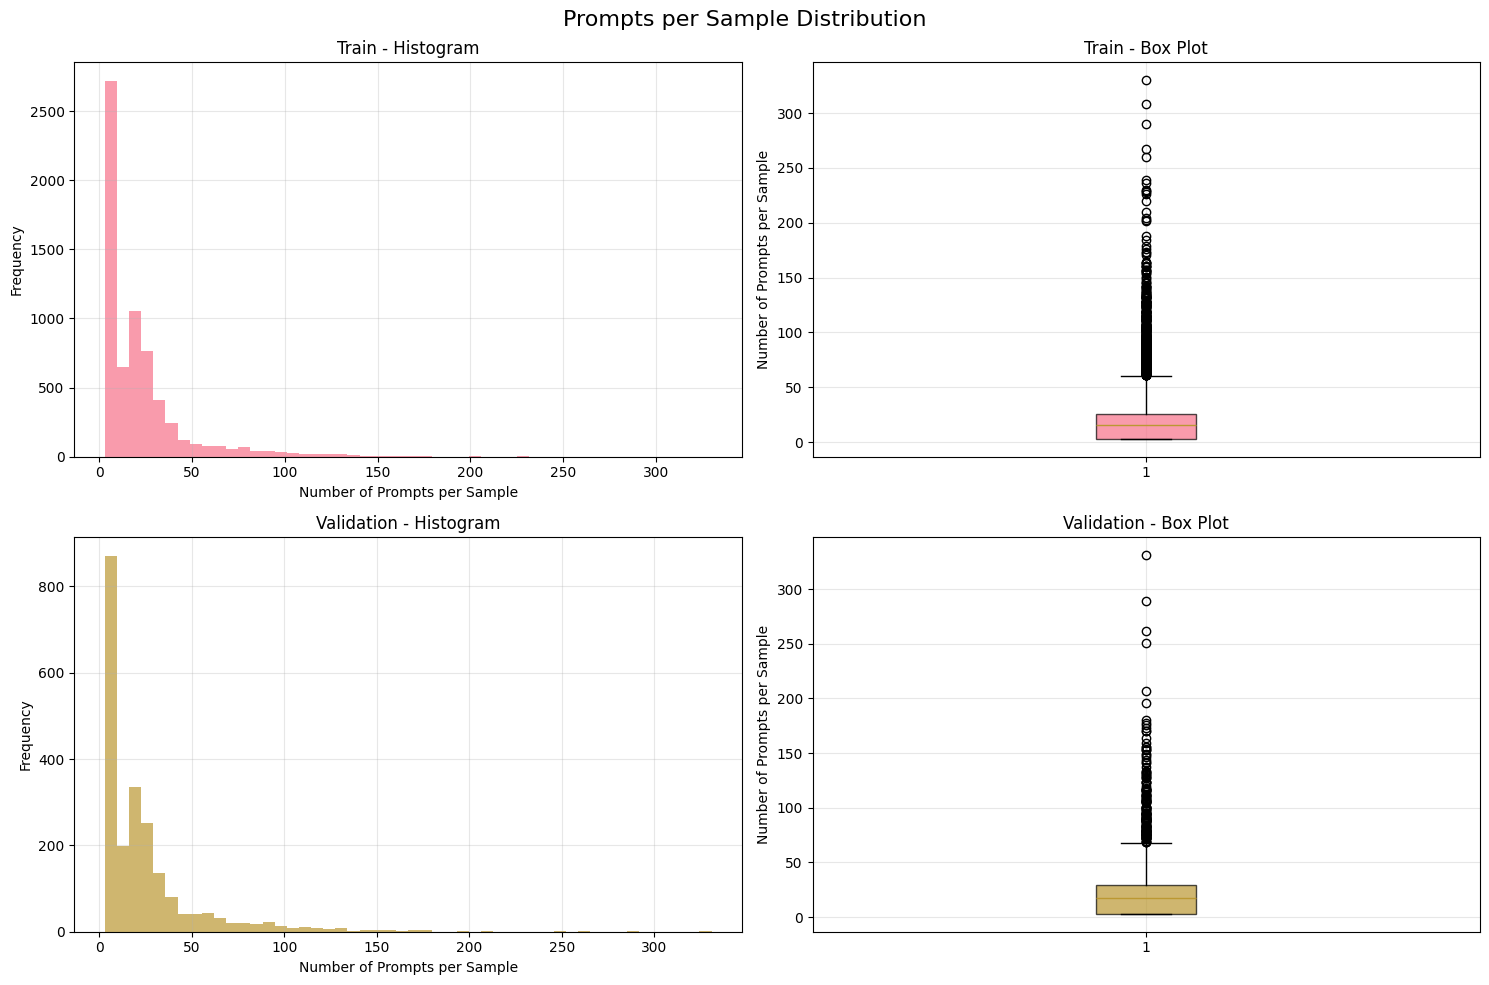

In [42]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
figure.suptitle('Prompts per Sample Distribution', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    counts = analysis['sample_prompt_counts']
    
    axes[i, 0].hist(counts, bins=50, alpha=0.7, color=f'C{i}')
    axes[i, 0].set_title(f'{name} - Histogram')
    axes[i, 0].set_xlabel('Number of Prompts per Sample')
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].grid(True, alpha=0.3)
    
    axes[i, 1].boxplot(counts, patch_artist=True, 
                       boxprops=dict(facecolor=f'C{i}', alpha=0.7))
    axes[i, 1].set_title(f'{name} - Box Plot')
    axes[i, 1].set_ylabel('Number of Prompts per Sample')
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

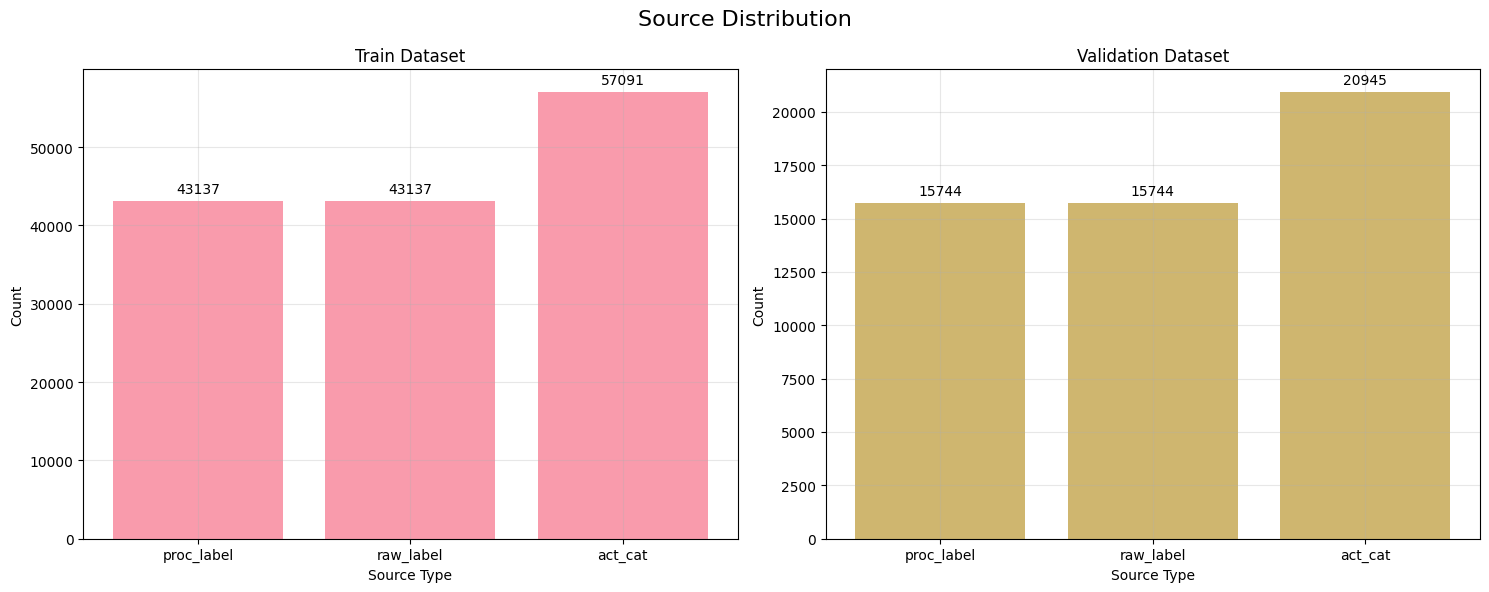

In [43]:
figure, axes = plt.subplots(1, 2, figsize=(15, 6))
figure.suptitle('Source Distribution', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    sources = list(analysis['source_counts'].keys())
    counts = list(analysis['source_counts'].values())
    
    axes[i].bar(sources, counts, color=f'C{i}', alpha=0.7)
    axes[i].set_title(f'{name} Dataset')
    axes[i].set_xlabel('Source Type')
    axes[i].set_ylabel('Count')
    axes[i].grid(True, alpha=0.3)
    
    for j, (source, count) in enumerate(zip(sources, counts)):
        axes[i].text(j, count + max(counts)*0.01, str(count), 
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

<div class="alert alert-info">

</div>

<div class="alert alert-warning">

**TODO:** Rather than doing pies for the count only we should do it for the durations.

</div>

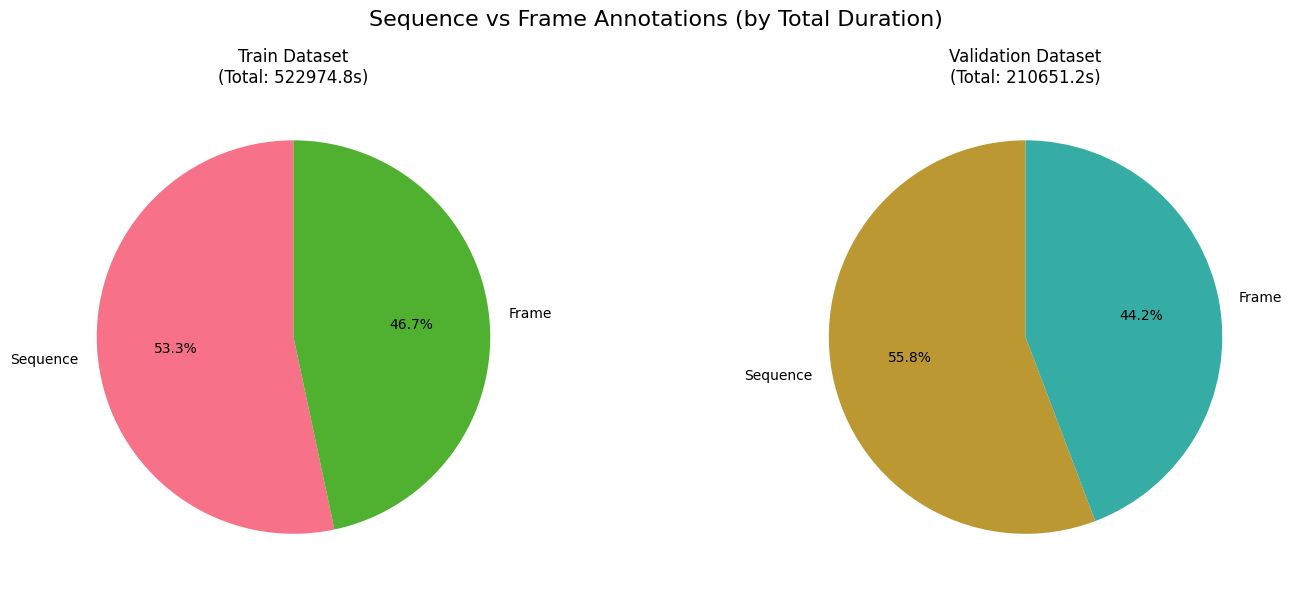

=== SEQUENCE VS FRAME DURATION STATISTICS ===

Train Dataset:
  Sequence: 22720 prompts (5578856 frames = 278942.8s)
  Frame: 120645 prompts (4880641 frames = 244032.0s)
  Total: 143365 prompts (10459497 frames = 522974.8s)
--------------------------------------------------

Validation Dataset:
  Sequence: 7794 prompts (2349296 frames = 117464.8s)
  Frame: 44639 prompts (1863729 frames = 93186.4s)
  Total: 52433 prompts (4213025 frames = 210651.2s)
--------------------------------------------------


In [44]:
figure, axes = plt.subplots(1, 2, figsize=(15, 6))
figure.suptitle('Sequence vs Frame Annotations (by Total Duration)', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    labels = ['Sequence', 'Frame']
    
    total_sequence_duration = sum(analysis['sequence_durations']) if analysis['sequence_durations'] else 0
    total_frame_duration = sum(analysis['frame_durations']) if analysis['frame_durations'] else 0
    durations = [total_sequence_duration, total_frame_duration]
    
    durations_seconds = [d / DEFAULT_FPS for d in durations]
    
    axes[i].pie(durations_seconds, labels=labels, autopct='%1.1f%%', startangle=90,
                colors=[f'C{i}', f'C{i+2}'])
    axes[i].set_title(f'{name} Dataset\n(Total: {sum(durations_seconds):.1f}s)')

plt.tight_layout()
plt.show()

print("=== SEQUENCE VS FRAME DURATION STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    seq_count = analysis['is_sequence_counts'][True]
    frame_count = analysis['is_sequence_counts'][False]
    seq_duration = sum(analysis['sequence_durations']) if analysis['sequence_durations'] else 0
    frame_duration = sum(analysis['frame_durations']) if analysis['frame_durations'] else 0
    
    print(f"\n{name} Dataset:")
    print(f"  Sequence: {seq_count} prompts ({seq_duration} frames = {seq_duration/DEFAULT_FPS:.1f}s)")
    print(f"  Frame: {frame_count} prompts ({frame_duration} frames = {frame_duration/DEFAULT_FPS:.1f}s)")
    print(f"  Total: {seq_count + frame_count} prompts ({seq_duration + frame_duration} frames = {(seq_duration + frame_duration)/DEFAULT_FPS:.1f}s)")
    print("-" * 50)

<div class="alert alert-info">

</div>

<div class="alert alert-warning">

**TODO:** The durations should be in frames not in seconds.

</div>

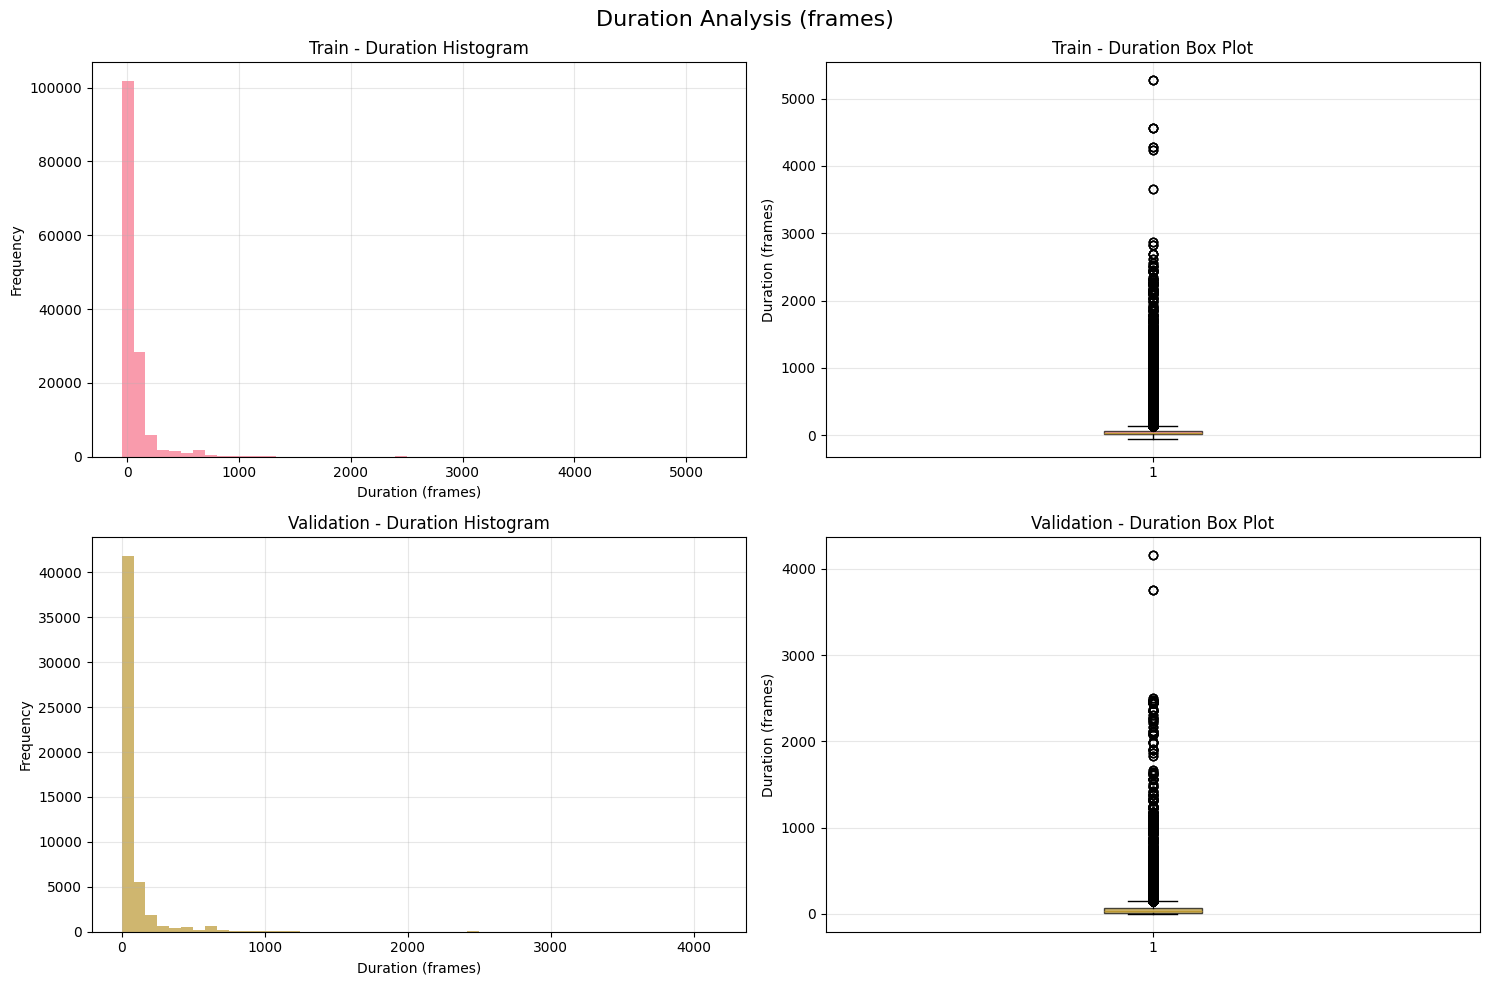

In [45]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
figure.suptitle('Duration Analysis (frames)', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    durations = analysis['durations']
    
    if durations:
        axes[i, 0].hist(durations, bins=50, alpha=0.7, color=f'C{i}')
        axes[i, 0].set_title(f'{name} - Duration Histogram')
        axes[i, 0].set_xlabel('Duration (frames)')
        axes[i, 0].set_ylabel('Frequency')
        axes[i, 0].grid(True, alpha=0.3)
        
        axes[i, 1].boxplot(durations, patch_artist=True, 
                           boxprops=dict(facecolor=f'C{i}', alpha=0.7))
        axes[i, 1].set_title(f'{name} - Duration Box Plot')
        axes[i, 1].set_ylabel('Duration (frames)')
        axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/home/nadir/disk/tmp/ipykernel_3963010/2975633751.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(prompt_counts, labels=datasets, patch_artist=True,
/home/nadir/disk/tmp/ipykernel_3963010/2975633751.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2].boxplot(durations, labels=datasets, patch_artist=True,


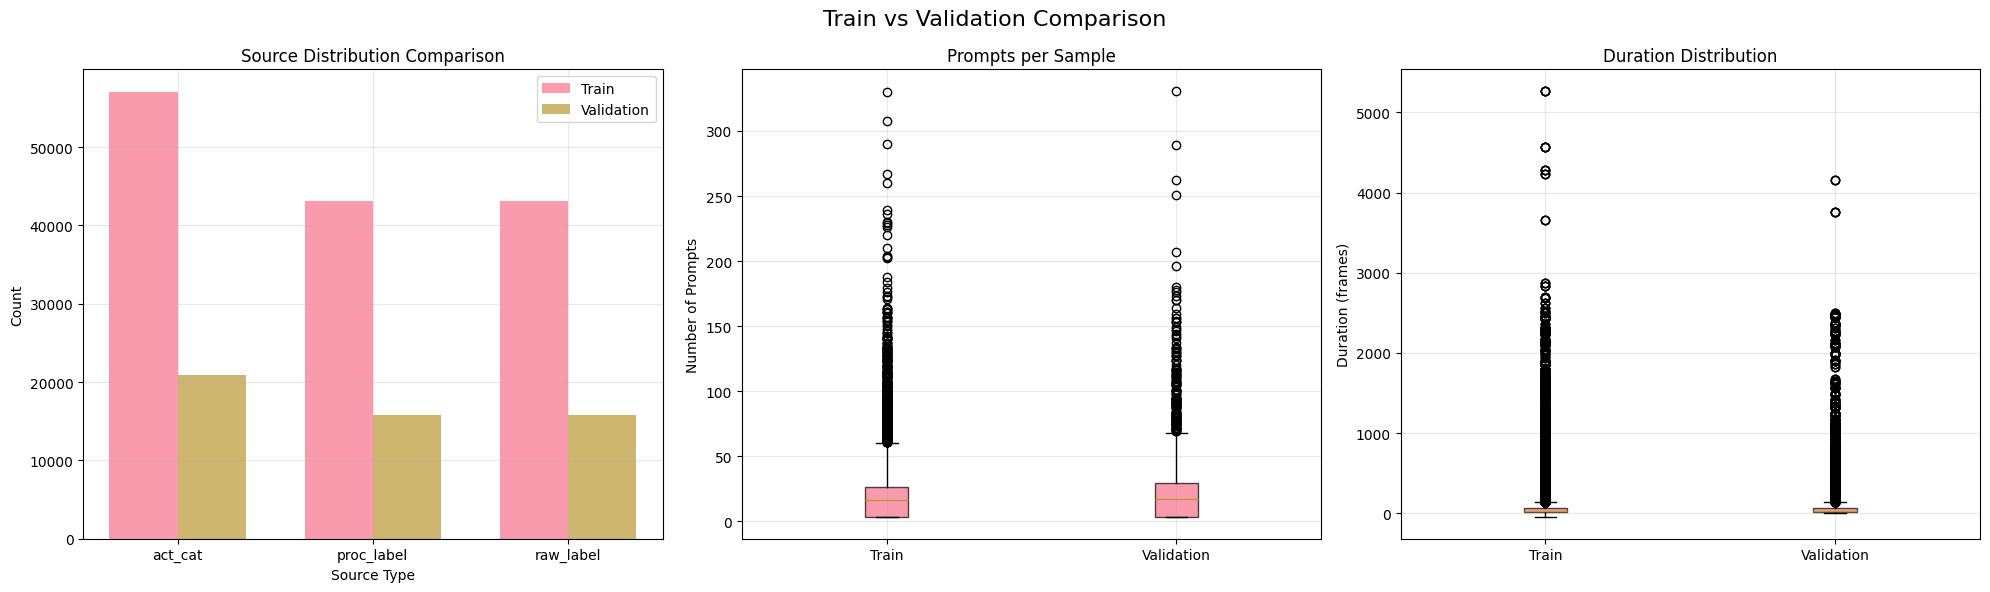

In [46]:
figure, axes = plt.subplots(1, 3, figsize=(20, 6))
figure.suptitle('Train vs Validation Comparison', fontsize=16)

datasets = ['Train', 'Validation']
colors = ['C0', 'C1']

source_data = {}
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    source_data[name] = analysis['source_counts']

all_sources = set()
for data in source_data.values():
    all_sources.update(data.keys())
all_sources = sorted(all_sources)

x = np.arange(len(all_sources))
width = 0.35

for i, (name, data) in enumerate(source_data.items()):
    counts = [data.get(source, 0) for source in all_sources]
    axes[0].bar(x + i*width, counts, width, label=name, color=colors[i], alpha=0.7)

axes[0].set_title('Source Distribution Comparison')
axes[0].set_xlabel('Source Type')
axes[0].set_ylabel('Count')
axes[0].set_xticks(x + width/2)
axes[0].set_xticklabels(all_sources)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

prompt_counts = [train_analysis['sample_prompt_counts'], validation_analysis['sample_prompt_counts']]
axes[1].boxplot(prompt_counts, labels=datasets, patch_artist=True,
                boxprops=dict(alpha=0.7))
axes[1].set_title('Prompts per Sample')
axes[1].set_ylabel('Number of Prompts')
axes[1].grid(True, alpha=0.3)

durations = [train_analysis['durations'], validation_analysis['durations']]
axes[2].boxplot(durations, labels=datasets, patch_artist=True,
                boxprops=dict(alpha=0.7))
axes[2].set_title('Duration Distribution')
axes[2].set_ylabel('Duration (frames)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [47]:
print("=== MOST COMMON PROMPTS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    prompt_counter = Counter(analysis['all_prompts'])
    
    print(f"\n{name} Dataset - Top 10 Most Common Prompts:")
    for i, (prompt, count) in enumerate(prompt_counter.most_common(10)):
        print(f"{i+1:2d}. ({count:4d}x) {prompt}")
    
    print(f"\n{name} Dataset - Top 10 Least Common Prompts:")
    least_common = prompt_counter.most_common()[-10:]
    for i, (prompt, count) in enumerate(reversed(least_common)):
        print(f"{i+1:2d}. ({count:4d}x) {prompt}")
    
    print("-" * 80)

=== MOST COMMON PROMPTS ===

Train Dataset - Top 10 Most Common Prompts:
 1. (31785x) transition
 2. (10469x) walk
 3. (9876x) stand
 4. (2569x) turn
 5. (2503x) hand movements
 6. (2013x) interact with/use object
 7. (1843x) arm movements
 8. (1783x) standing
 9. (1772x) t pose
10. (1497x) tpose

Train Dataset - Top 10 Least Common Prompts:
 1. (   1x) 'Sit' and 'Stand
 2. (   1x) ' sit ' and ' stand
 3. (   1x) walk, turn around, sit down. stand up, walk
 4. (   1x) walk using hand rail
 5. (   1x) walk use hand rail
 6. (   1x) looking down to the right
 7. (   1x) Wiping something down
 8. (   1x) Throw ball
 9. (   1x) acting
10. (   1x) act
--------------------------------------------------------------------------------

Validation Dataset - Top 10 Most Common Prompts:
 1. (11543x) transition
 2. (3753x) stand
 3. (3459x) walk
 4. (1054x) turn
 5. (1013x) hand movements
 6. ( 724x) arm movements
 7. ( 720x) t pose
 8. ( 679x) standing
 9. ( 646x) interact with/use object
10. ( 59

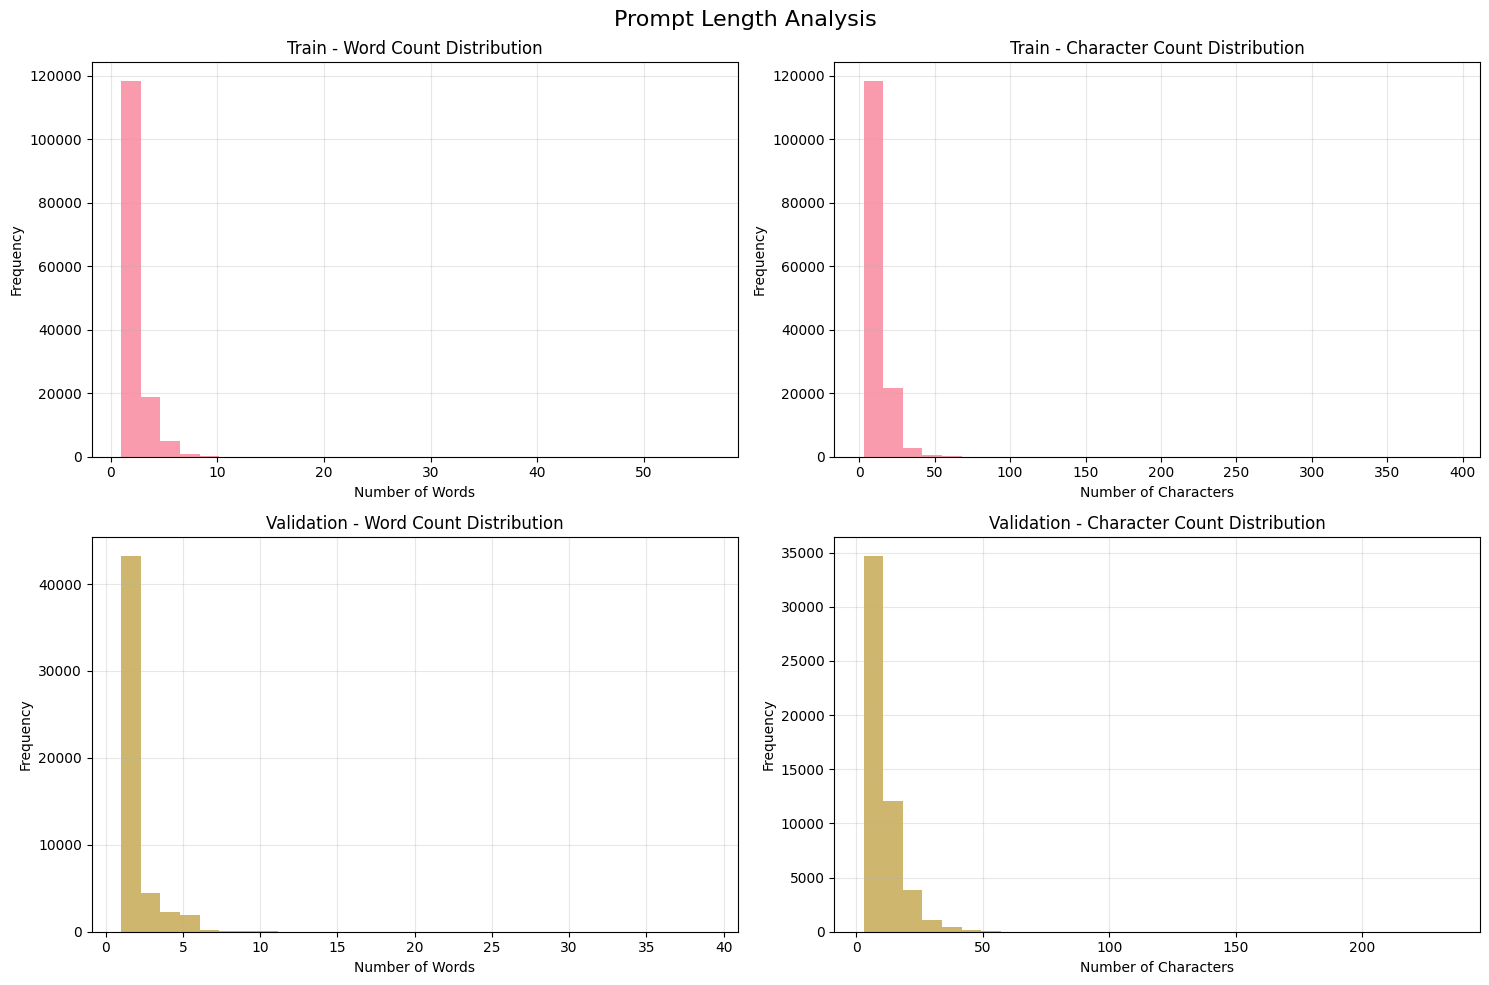

=== PROMPT LENGTH STATISTICS ===

Train Dataset:
  Word count - Min: 1, Mean: 1.74, Max: 56
  Char count - Min: 3, Mean: 10.58, Max: 392
--------------------------------------------------

Validation Dataset:
  Word count - Min: 1, Mean: 1.78, Max: 39
  Char count - Min: 3, Mean: 10.75, Max: 235
--------------------------------------------------


In [48]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
figure.suptitle('Prompt Length Analysis', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    prompt_lengths = [len(prompt.split()) for prompt in analysis['all_prompts']]
    char_lengths = [len(prompt) for prompt in analysis['all_prompts']]
    
    axes[i, 0].hist(prompt_lengths, bins=30, alpha=0.7, color=f'C{i}')
    axes[i, 0].set_title(f'{name} - Word Count Distribution')
    axes[i, 0].set_xlabel('Number of Words')
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].grid(True, alpha=0.3)
    
    axes[i, 1].hist(char_lengths, bins=30, alpha=0.7, color=f'C{i}')
    axes[i, 1].set_title(f'{name} - Character Count Distribution')
    axes[i, 1].set_xlabel('Number of Characters')
    axes[i, 1].set_ylabel('Frequency')
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== PROMPT LENGTH STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    prompt_lengths = [len(prompt.split()) for prompt in analysis['all_prompts']]
    char_lengths = [len(prompt) for prompt in analysis['all_prompts']]
    
    print(f"\n{name} Dataset:")
    print(f"  Word count - Min: {np.min(prompt_lengths)}, Mean: {np.mean(prompt_lengths):.2f}, Max: {np.max(prompt_lengths)}")
    print(f"  Char count - Min: {np.min(char_lengths)}, Mean: {np.mean(char_lengths):.2f}, Max: {np.max(char_lengths)}")
    print("-" * 50)

In [ ]:
def analyze_source_duration_correlation(dataset, dataset_name):
    """Analyze correlation between source types and durations"""
    source_durations = defaultdict(list)
    
    for sample in dataset:
        prompts_list = sample.get("prompts", [])
        
        for prompt_data in prompts_list:
            span = prompt_data.get("span", [])
            source = prompt_data.get("source", "unknown")
            
            if len(span) == 2:
                duration_frames = span[1] - span[0]
                source_durations[source].append(duration_frames)
    
    return source_durations

train_source_durations = analyze_source_duration_correlation(train_dataset, "Train")
validation_source_durations = analyze_source_duration_correlation(validation_dataset, "Validation")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Duration by Source Type', fontsize=16)

for i, (source_durations, name) in enumerate([(train_source_durations, "Train"), 
                                              (validation_source_durations, "Validation")]):
    sources = list(source_durations.keys())
    duration_data = [source_durations[source] for source in sources]
    
    bp = axes[i].boxplot(duration_data, labels=sources, patch_artist=True)
    axes[i].set_title(f'{name} Dataset')
    axes[i].set_xlabel('Source Type')
    axes[i].set_ylabel('Duration (frames)')
    axes[i].grid(True, alpha=0.3)
    
    for patch, color in zip(bp['boxes'], ['C0', 'C1', 'C2']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

plt.tight_layout()
plt.show()

print("=== DURATION BY SOURCE STATISTICS ===")
for source_durations, name in [(train_source_durations, "Train"), 
                               (validation_source_durations, "Validation")]:
    print(f"\n{name} Dataset:")
    for source, durations in source_durations.items():
        if durations:
            print(f"  {source}: {len(durations)} prompts, "
                  f"duration mean: {np.mean(durations):.2f} frames ({np.mean(durations)/DEFAULT_FPS:.2f}s), "
                  f"std: {np.std(durations):.2f} frames ({np.std(durations)/DEFAULT_FPS:.2f}s)")
    print("-" * 50)

In [ ]:
print("=== SPANS PER PROMPT ANALYSIS ===")

def analyze_spans_per_prompt(analysis, name):
    """Analyze how many spans each unique prompt text has"""
    spans_per_prompt = analysis['spans_per_prompt']
    
    prompt_span_counts = {}
    for prompt_text, spans in spans_per_prompt.items():
        prompt_span_counts[prompt_text] = len(spans)
    
    span_counts = list(prompt_span_counts.values())
    
    return {
        'prompt_span_counts': prompt_span_counts,
        'span_counts': span_counts,
        'unique_prompts': len(spans_per_prompt),
        'total_spans': sum(span_counts)
    }

train_spans_analysis = analyze_spans_per_prompt(train_analysis, "Train")
validation_spans_analysis = analyze_spans_per_prompt(validation_analysis, "Validation")

for spans_analysis, name in [(train_spans_analysis, "Train"), 
                             (validation_spans_analysis, "Validation")]:
    print(f"\n{name} Dataset:")
    print(f"  Unique prompts: {spans_analysis['unique_prompts']}")
    print(f"  Total spans: {spans_analysis['total_spans']}")
    print(f"  Avg spans per unique prompt: {np.mean(spans_analysis['span_counts']):.2f}")
    print(f"  Min spans per prompt: {np.min(spans_analysis['span_counts'])}")
    print(f"  Max spans per prompt: {np.max(spans_analysis['span_counts'])}")
    print(f"  Std spans per prompt: {np.std(spans_analysis['span_counts']):.2f}")
    
    span_count_dist = Counter(spans_analysis['span_counts'])
    print(f"  Distribution of spans per prompt:")
    for span_count in sorted(span_count_dist.keys()):
        count = span_count_dist[span_count]
        print(f"    {span_count} spans: {count} prompts ({count/spans_analysis['unique_prompts']*100:.1f}%)")
    print("-" * 50)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Spans per Unique Prompt Analysis', fontsize=16)

for i, (spans_analysis, name) in enumerate([(train_spans_analysis, "Train"), 
                                            (validation_spans_analysis, "Validation")]):
    span_counts = spans_analysis['span_counts']
    
    axes[i, 0].hist(span_counts, bins=range(1, max(span_counts)+2), alpha=0.7, color=f'C{i}')
    axes[i, 0].set_title(f'{name} - Spans per Prompt Histogram')
    axes[i, 0].set_xlabel('Number of Spans per Unique Prompt')
    axes[i, 0].set_ylabel('Number of Prompts')
    axes[i, 0].grid(True, alpha=0.3)
    
    axes[i, 1].boxplot(span_counts, patch_artist=True, 
                       boxprops=dict(facecolor=f'C{i}', alpha=0.7))
    axes[i, 1].set_title(f'{name} - Spans per Prompt Box Plot')
    axes[i, 1].set_ylabel('Number of Spans per Unique Prompt')
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== PROMPTS WITH MOST SPANS ===")
for spans_analysis, analysis, name in [(train_spans_analysis, train_analysis, "Train"), 
                                       (validation_spans_analysis, validation_analysis, "Validation")]:
    print(f"\n{name} Dataset - Top 10 prompts with most spans:")
    sorted_prompts = sorted(spans_analysis['prompt_span_counts'].items(), 
                           key=lambda x: x[1], reverse=True)
    
    for i, (prompt, span_count) in enumerate(sorted_prompts[:10]):
        print(f"{i+1:2d}. ({span_count:2d} spans) {prompt}")
    print("-" * 80)